# Example calculations with scalar quantities

## Objectives

To demonstrate basic calculations using scalar fields (e.g., SSH, T, S) from the state estimate including: time series of mean quantities, spatial patterns of mean quantities, spatial patterns of linear trends, and spatial patterns of linear trends over different time periods.

## Introduction

We will demonstrate global calculations with SSH (global mean sea level time series, mean dynamic topography, global mean sea level trend) and a regional calculation with THETA (nino 3.4 index).

## Global calculations with SSH

First, load all 13 tiles for sea surface height and the model grid parameters and merge the two `Datasets`.

In [1]:
import numpy as np
from copy import deepcopy 
import xarray as xr
import sys
import matplotlib.pylab as plt
import numpy as np
import warnings
from mpl_toolkits.basemap import Basemap
warnings.filterwarnings('ignore')

%matplotlib inline
sys.path.append('/Users/ifenty/git_repo_mine/ECCOv4-py')
import ecco_v4_py as ecco

In [2]:
# Set this to be the directory for your fields
ECCO_dir = '/Users/ifenty/ECCOv4/R3'

# Load all tiles of the LLC90 Grid    
data_dir= ECCO_dir + '/nctiles_grid/'    
var = 'GRID'
var_type = 'grid'

grid_all_tiles = ecco.load_all_tiles_from_netcdf(data_dir, 
                                                 var, var_type,
                                                 less_output=True)

# Load all tiles of SSH
data_dir= ECCO_dir + '/nctiles_monthly/SSH/'    
var = 'SSH'
var_type = 'c'
ssh_all_tiles = ecco.load_all_tiles_from_netcdf(data_dir, 
                                                var, var_type,
                                                less_output=True)

# Merge the grid parameters and SSH Datasets
v4 = xr.merge([ssh_all_tiles,grid_all_tiles])

Finished loading all 13 tiles of GRID
Finished loading all 13 tiles of SSH


## Sea surface height

### Global mean sea level

Global mean sea surface height at time $t$ is defined as follows:

$$SSH_{\text{global mean}}(t) = \frac{\sum_{i} SSH(i,t) \,\, A(i)}{A_{\text{global ocean}}}$$

$$A_{\text{global ocean}} = \sum_{i} A(i)$$

Where $SSH(i,t)$ is dynamic height at model grid cell $i$ and time $t$, $A(i)$ is the area (m^2) of model grid cell $i$

There are several ways of doing the above calculations.  Since this is the first tutorial with actual calcuations, we'll present a few different approaches for getting to the same answer.

#### Part 1: $A_{\text{global ocean}}$

Let's start on the simplest quantity, the global ocean surface area $A_{\text{global ocean}}$.  Our calculation uses $SSH$ which is a 'c' point variable.  The surface area of tracer grid cells is provided by the model grid parameter $RAC$.  $RAC$ is a two-dimensional field that is defined over all model grid points, including land.  To calculate the total ocean surface area we therefore need to ignore the area contributions from land. The wet/dry mask at 'c' points is provided by the $land_c$ variable: 1 for wet cells, 0 for dry cells.  Because this wet/dry mask varies with depth, $land_c$ is three-dimensional.

To illustrate the depth dependence of $land_c$ here are the wet/dry masks for the uppermost grid cell (centered at z=5m) and the 35th grid cell in teh vertical (centered at z=1634 m):

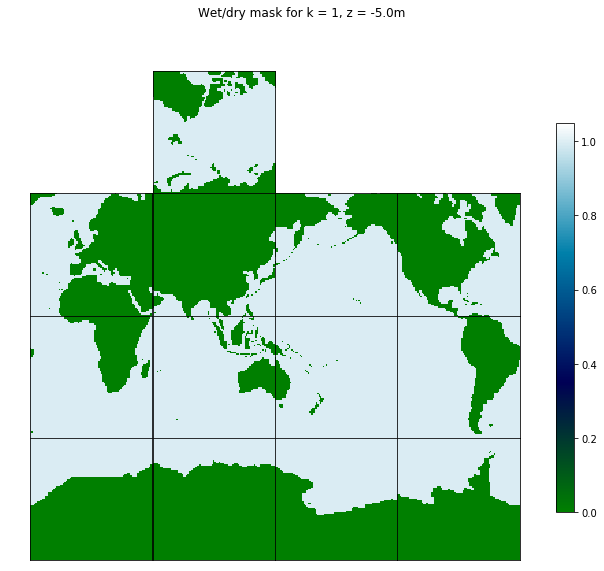

In [3]:
# select the uppermost grid cell, k = 1
k_level = 1
ecco.plot_tiles(v4.land_c.sel(k=k_level),layout='latlon',
                rotate_to_latlon = True, user_cmap='ocean',
                cmin=0, cmax=1.05,tile_labels=False, cbar=True);

# select out the model depth at k=1, round the number and convert to string.
z = np.array_str((np.round(v4.RC.sel(k=k_level).values)))

plt.suptitle('Wet/dry mask for k = ' + str(k_level) + ', z = ' + z + 'm');

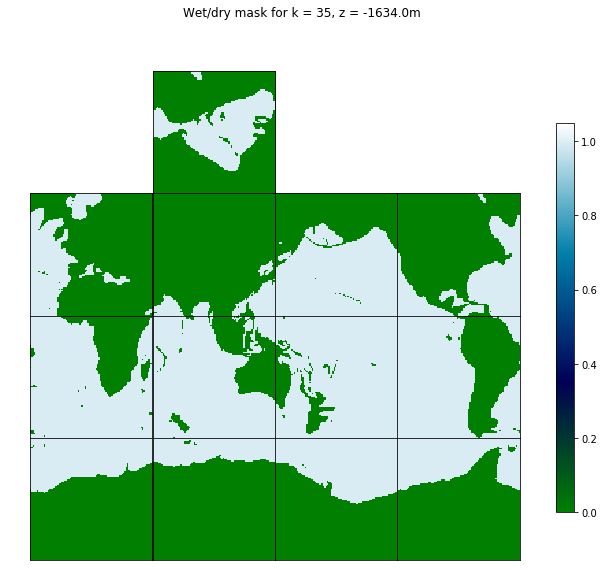

In [4]:
# select the 35th grid cell, k = 35
k_level = 35
ecco.plot_tiles(v4.land_c.sel(k=k_level),layout='latlon',
                rotate_to_latlon = True, user_cmap='ocean',
                cmin=0, cmax=1.05,tile_labels=False, cbar=True);

z = np.array_str((np.round(v4.RC.sel(k=k_level).values)))
plt.suptitle('Wet/dry mask for k = ' + str(k_level) + ', z = ' + z + 'm');

To calculate $A_{\text{global ocean}}$ we must apply the surface wet/dry mask to $RAC$.  

There are three alternative ways of selecting the surface layer from $land_c$.  First, note that $k$ is the second dimension of $land_c$:

In [5]:
v4.land_c.dims

('tile', 'k', 'j', 'i')

In [6]:
# Method 1: the array index method, []
#           select land_c at k index 0
total_ocean_area = np.sum(v4.RAC*v4.land_c[:,0,:,:])

# Method 2: the coordinate index method, isel() 
#           select land_c at k index 0
total_ocean_area_B = np.sum(v4.RAC*v4.land_c.isel(k=0))

# Method 3: the coordinate label method, sel()
#           select land_c at k coordinate label 1 
total_ocean_area_C = np.sum(v4.RAC*v4.land_c.sel(k=1))


# these three methods give the same numerical result.  Here are 
# three alternative ways of printing the result
print 'total ocean surface area (m^2) ', total_ocean_area.values
print 'total ocean surface area (km^2)', total_ocean_area_B.values/1e6

# or in scientific notation with 2 decimal points
print 'total ocean surface area (km^2) ' + '%.2E' % (total_ocean_area_C.values/1e6)

total ocean surface area (m^2)  358013858260160.0
total ocean surface area (km^2) 358013858.26016
total ocean surface area (km^2) 3.58E+08


This compares favorable with *Global surface area of Earth's Oceans : approx 3.60 x $10^8$ $km^2$* from https://hypertextbook.com/facts/1997/EricCheng.shtml

##### Multiplication of DataArrays
You probably noticed that the multiplication of grid cell area with the land mask was done element by element.  One useful feature of `DataArrays` is that their dimensions are automatically lined up when doing binary operations.  Also, because $v4.RAC$ and $v4.land_c$ are both `DataArrays`, their inner product and their sum are also $total_ocean_area$ variables are also DataArrays.  $land_c$ had a $k$ dimension and $RAC$ did not.  The result of their product inherits the $k$ dimension:*

##### Another way of summing over `numpy` arrays

As $RAC$ and $land_c$ both store `numpy` arrays, you can also calculate the sum of their product by invoking the `.sum()` command inherited in all `numpy arrays`:

In [7]:
total_ocean_area_D = (v4.RAC*v4.land_c.sel(k=1)).values.sum()
print 'total ocean surface area (km^2) ' + '%.2E' % (total_ocean_area_C.values/1e6)

total ocean surface area (km^2) 3.58E+08


#### Part2 : $SSH_{\text{global mean}}(t)$

The global mean SSH at each $t$ is given by,

$$SSH_{\text{global mean}}(t) = \frac{\sum_{i} SSH(i,t) \,\, A(i)}{A_{\text{global ocean}}}$$

One way of calculating this is to take advantage of `DataArray` coordinate labels and use its *.sum()* functionality to explicitly specify which dimensions to sum over:

In [8]:
# note no need to multiple RAC by land_c because SSH is nan over land
SSH_global_mean = (v4.SSH*v4.RAC).sum(dim=['i','j','tile'])/total_ocean_area
SSH_global_mean

<xarray.DataArray (time: 288)>
array([0.109695, 0.101452, 0.096804, ..., 0.173514, 0.173005, 0.171855])
Coordinates:
  * time      (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
    tim       (time) datetime64[ns] 1992-01-16 1992-02-16 1992-03-16 ...
    timestep  (time) float64 732.0 1.428e+03 2.172e+03 2.892e+03 3.636e+03 ...
    k         float64 1.0

Alternatively we can do the summation over the three non-time dimensions.  The time dimension of SSH is along the first dimension (axis) of the array, axis 0.

In [9]:
# note no need to multiple RAC by land_c because SSH is nan over land
SSH_global_mean = np.sum(v4.SSH*v4.RAC,axis=(1,2,3))/total_ocean_area
SSH_global_mean

<xarray.DataArray (time: 288)>
array([0.109695, 0.101452, 0.096804, ..., 0.173514, 0.173005, 0.171855])
Coordinates:
  * time      (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
    tim       (time) datetime64[ns] 1992-01-16 1992-02-16 1992-03-16 ...
    timestep  (time) float64 732.0 1.428e+03 2.172e+03 2.892e+03 3.636e+03 ...
    k         float64 1.0

Even though $SSH$ has 3 dimensions (time, j, i) and $RAC$ and $land_c.sel(k=1)$ have 2 (j,i), we can mulitply them and the element-by-element multiplication occurs over their common dimension.

The resulting $SSH_{global-mean}$ `DataArray` has a single dimension, time.

#### Part 3 : Plotting the global mean sea level time series:

Before we plot the global mean sea level curve let's remove its time-mean to make it global mean sea level anomaly (the absolute value has no meaning here anyway).

Text(0.5,0,u'year')

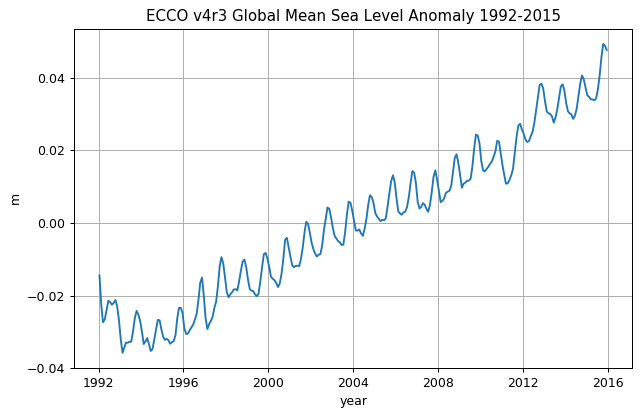

In [10]:
# Method 1: .mean() method of `DataArrays`
SSH_global_mean_anomaly = SSH_global_mean - SSH_global_mean.mean()

# Method 2: numpy's `mean` method 
SSH_global_mean_anomaly = SSH_global_mean - np.mean(SSH_global_mean)

plt.figure(figsize=(8,5), dpi= 90)
plt.plot(v4.tim, SSH_global_mean_anomaly)
plt.grid()
plt.title('ECCO v4r3 Global Mean Sea Level Anomaly 1992-2015');
plt.ylabel('m');
plt.xlabel('year')

*GMSL is not well constrained by observations prior to the start of TOPEX/Poseidon data collection in late 1992.*

### Mean Dynamic Topography

Mean dynamic topography is calculated as follows,

$$MDT(i) = \frac{\sum_{t} SSH(i,t) - SSH_{\text{global mean}}(t)}{nt} $$

Where $nt$ is the number of time records. 

For $MDT$ we presere the spatial dimensions. Summation and averaging are over the time dimensions (axis 0).

In [11]:
## Two equivalent methods

# Method 1, specify the axis over which to average
MDT = np.mean(v4.SSH - SSH_global_mean,axis=0)

# Method 2, specify the coordinate label over which to average
MDT_B = (v4.SSH - SSH_global_mean).mean(dim=['time'])

# which can be verified using the '.equals()' method to compare Datasets and DataArrays
print(MDT.equals(MDT_B))

True


As expected, MDT has preserved its spatial dimensions:

In [12]:
MDT.dims

('tile', 'j', 'i')

Before plotting the MDT field remove its spatial mean since its spatial mean conveys no dynamically useful information.  

In [13]:
MDT_no_spatial_mean = MDT - MDT*v4.RAC/total_ocean_area

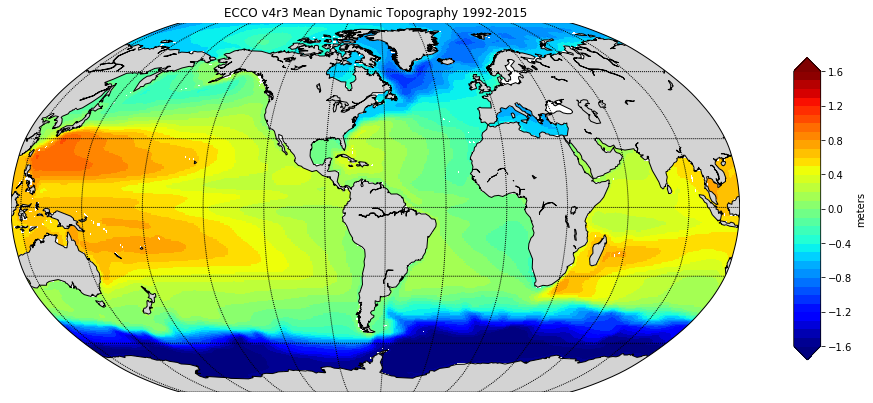

In [14]:
plt.figure(figsize=(15,7))
my_cmin =-1.6; my_cmax=1.6;  my_cint=.1
my_num_levels = len(np.arange(my_cmin,my_cmax+my_cint, my_cint))

f, ax, m = ecco.plot_tiles_proj(v4.XC, v4.YC, MDT_no_spatial_mean,
                                plot_type='contourf', 
                                cbar=True, cbar_label='meters',
                                lon_0 = 115, 
                                cmin=my_cmin, cmax=my_cmax, 
                                num_levels = my_num_levels)

plt.title('ECCO v4r3 Mean Dynamic Topography 1992-2015');

### Spatial variations of sea level linear trends  

To calculate the linear trend for the each model point we will rely on the `polyfit` function of `numpy`.  First, define a time variable in years for SSH.

In [15]:
time_years = v4.SSH.time.values /12

Next, reshape the four dimensional SSH field into two dimensions, time and space (t, i)

In [16]:
ssh_tmp = np.copy(np.reshape(v4.SSH.values,(288, 13*90*90)))
# where 288 is the number of time records in ECCO v4 r3 [1992-2015] and
# 13*90*90 is the number of surface grid points, 13 tiles each of 90x90 cells

Now set all $SSH$ values that are 'nan' to zero because the polynominal fitting
routine can't handle nans,

In [17]:
ssh_tmp[np.isnan(ssh_tmp)]=0.0

Do the polynomial fitting, https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.polyfit.html

In [18]:
ssh_slope, ssh_intercept = np.polyfit(time_years, ssh_tmp , 1)
    
# and reshape the slope result back to 13x90x90    
ssh_slope = np.reshape(ssh_slope, (13, 90,90))

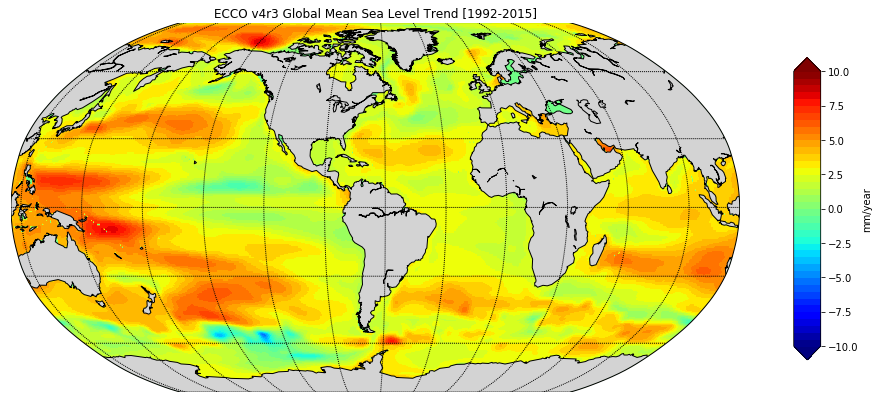

In [19]:
plt.figure(figsize=(15,7))

my_cmin =-10; my_cmax=10;   my_cint=.5
my_num_levels = len(np.arange(my_cmin,my_cmax+my_cint, my_cint))
    
f, ax, m = ecco.plot_tiles_proj(v4.XC, v4.YC, ssh_slope*1e3, # from m/yr to mm/year
                                plot_type='contourf', 
                                cbar=True, cbar_label='mm/year',
                                lon_0 = 115, cmin=my_cmin, cmax=my_cmax, 
                                num_levels = my_num_levels)

plt.title('ECCO v4r3 Global Mean Sea Level Trend [1992-2015]');

### Spatial variations of sea level linear trends over two epochs 

Now we will repeat the last exercise but split the analysis into two 12 year epochs, Jan 1992 to 2003 and Jan 2004 to Dec 2015.

In [20]:
# Epoch 1, Jan 1992 to Dec 2003
time_years_1 = v4.SSH.time[0:144].values /12
# Epoch 2, Jan 2004 to Dec 2015
time_years_2 = v4.SSH.time[144:289].values /12

In [21]:
# np.arange makes arrays from (a, b-1).  So np.arange(1,145) makes an array from 1, 2.. 144

# select out time coordinates with labels from 1 to 144
ssh_tmp_1 = np.copy(np.reshape(v4.SSH.sel(time=np.arange(1,145)).values,(144, 13*90*90)))
# select out time coordinates with labels from 145 to 288
ssh_tmp_2 = np.copy(np.reshape(v4.SSH.sel(time=np.arange(145,289)).values,(144, 13*90*90)))

In [22]:
# set nans to zero
ssh_tmp_1[np.isnan(ssh_tmp_1)]=0.0
ssh_tmp_2[np.isnan(ssh_tmp_2)]=0.0

In [23]:
# calculate slopes
ssh_slope_1, ssh_intercept_1 = np.polyfit(time_years_1, ssh_tmp_1, 1)
ssh_slope_2, ssh_intercept_2 = np.polyfit(time_years_2, ssh_tmp_2, 1)
    
# and reshape the slopes arrays back to 13x90x90    
ssh_slope_1 = np.reshape(ssh_slope_1, (13, 90,90))
ssh_slope_2 = np.reshape(ssh_slope_2, (13, 90,90))

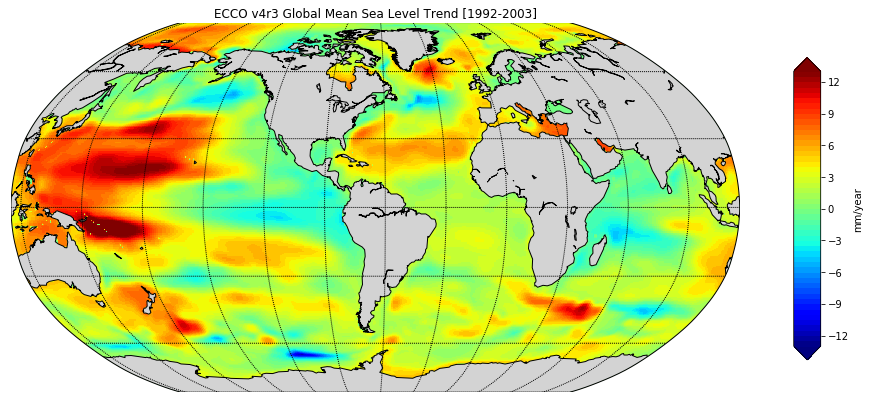

In [24]:
# Plot Epoch 1
plt.figure(figsize=(15,7))
my_cmin =-13; my_cmax=13;   my_cint=.5
my_num_levels = len(np.arange(my_cmin,my_cmax+my_cint, my_cint))    
f, ax, m = ecco.plot_tiles_proj(v4.XC, v4.YC, ssh_slope_1*1e3,
                                plot_type='contourf',  
                                cbar=True, cbar_label='mm/year',
                                lon_0 = 115, cmin=my_cmin, cmax=my_cmax, 
                                num_levels = my_num_levels)
plt.title('ECCO v4r3 Global Mean Sea Level Trend [1992-2003]');

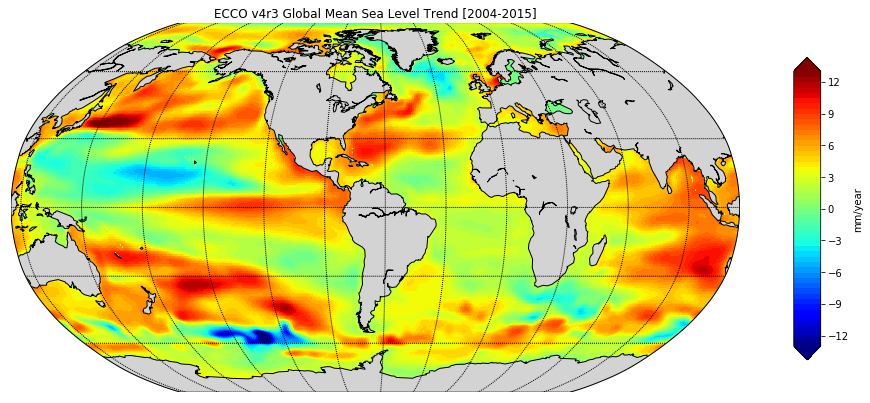

In [25]:
# Plot Epoch 2
plt.figure(figsize=(15,7))
my_cmin =-13; my_cmax=13;   my_cint=.5
my_num_levels = len(np.arange(my_cmin,my_cmax+my_cint, my_cint))
f, ax, m = ecco.plot_tiles_proj(v4.XC, v4.YC, ssh_slope_2*1e3, 
                                plot_type='contourf', 
                                cbar=True, cbar_label='mm/year',
                                lon_0 = 115, cmin=my_cmin, cmax=my_cmax, 
                                num_levels = my_num_levels)
plt.title('ECCO v4r3 Global Mean Sea Level Trend [2004-2015]');

## Regional calculations with THETA

In [26]:
# Load all tiles of THETA
data_dir= ECCO_dir + '/nctiles_monthly/THETA/'    
var = 'THETA'
var_type = 'c'
theta_all_tiles = ecco.load_all_tiles_from_netcdf(data_dir, 
                                                var, var_type,
                                                less_output=True)
# Merge the grid parameters and SSH Datasets
v4 = xr.merge([theta_all_tiles,v4])

Finished loading all 13 tiles of THETA


In [27]:
SST = v4.THETA.sel(k=1)

In [28]:
lat_bounds = np.logical_and(v4.YC >= -5, v4.YC <= 5)
lon_bounds = np.logical_and(v4.XC >= -170, v4.XC <= -120)

SST_masked=SST.where(np.logical_and(lat_bounds, lon_bounds));

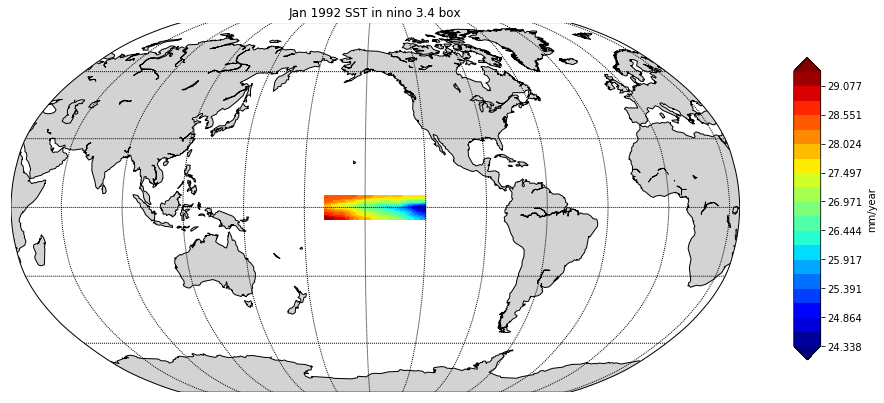

In [29]:
# Plot Epoch 1
plt.figure(figsize=(15,7))
#my_cmin =1; my_cmax=1;   my_cint=.1
#my_num_levels = len(np.arange(my_cmin,my_cmax+my_cint, my_cint))    

f, ax, m = ecco.plot_tiles_proj(v4.XC, v4.YC, SST_masked.sel(time=1),
                                plot_type='contourf',  
                                cbar=True, cbar_label='mm/year',
                                lon_0 = 35)

plt.title('Jan 1992 SST in nino 3.4 box');

In [30]:
# Create the same mask for the grid cell area
RAC_masked=v4.RAC.where(np.logical_and(lat_bounds, lon_bounds));

# Calculate the 
SST_masked_mean=(SST_masked*RAC_masked).sum(dim=['tile','j','i'])/np.sum(RAC_masked)

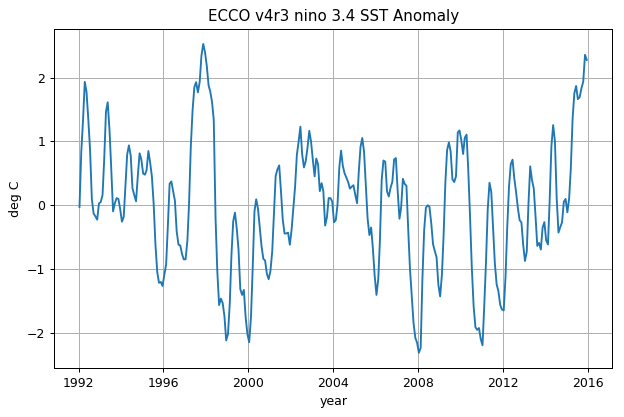

In [31]:
SST_nino_34_anom = SST_masked_mean - np.mean(SST_masked_mean)

plt.figure(figsize=(8,5), dpi= 90)
plt.plot(v4.tim, SST_nino_34_anom)
plt.grid()
plt.title('ECCO v4r3 nino 3.4 SST Anomaly');
plt.ylabel('deg C');
plt.xlabel('year');

## Conclusion

You now know how to do some basic calculations with scalar quantities!